# DSCI 100/Section 009/Group 169 Group Project Report

### Heart Disease Dataset Analysis Report
By: Shady Abo El Kasim, Nalan Goosen, Labella Li, Yusen Wu

#### Introduction

Heart disease refers to several different kinds of heart conditions with the most common one being coronary artery disease. Heart disease can be brought on by bad health habits such as smoking, it can be identified by features such as chest pain, and it may also be brought on by things outside of your control. We will attempt to find out if we can accurately predict whether or not a person has heart disease based on the characteristics of their health.

The dataset that we are using is the heart disease data set. It is sourced from the four hospitals listed below and the data was pulled on 26/10/2022. The dataset includes information about the patients including their biological information, health habits, current state of health, and whether or not they have heart disease.

Sources:

Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

In [2]:
### Please run this cell before continuing.

library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(2022) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Data Reading and Cleaning

In [3]:
# reading and cleaning dataset

heart_disease_data <- read_csv("https://raw.githubusercontent.com/labellali/dsci-100-2022w1-group-169/main/data/heart_disease_dataset.csv")
heart_disease_data <- heart_disease_data |>
    rename(age = Column1,
            sex = Column2,
                            chest_pain = Column3,
                            resting_blood_pressure = Column4,
                            cholesterol = Column5,
                            fasting_blood_sugar = Column6,
                            rest_ecg = Column7,
                            max_heart_rate = Column8,
                            exercised_ind_angina = Column9,
                            oldpeak = Column10,
                            slope = Column11,
                            ca = Column12,
                            thal = Column13,
                            num = Column14) |>
    mutate(num = as.factor(num),
          thal = na_if(thal, '?'),
          thal = as.factor(thal),
          ca = na_if(ca, '?'), 
          ca = as.numeric(ca),
          num = replace(num, num == 2, 1),
          num = replace(num, num == 3, 1),
          num = replace(num, num == 4, 1)) |> 
    select(resting_blood_pressure,
           chest_pain,
           cholesterol,
           max_heart_rate,
           num) |>
    filter(resting_blood_pressure != is.na(resting_blood_pressure),
           chest_pain != is.na(chest_pain),
           cholesterol != is.na(cholesterol),
           max_heart_rate != is.na(max_heart_rate),
           num != is.na(num))
heart_disease_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Column12, Column13
dbl (12): Column1, Column2, Column3, Column4, Column5, Column6, Column7, Col...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


resting_blood_pressure,chest_pain,cholesterol,max_heart_rate,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
145,1,233,150,0
160,4,286,108,1
120,4,229,129,1
⋮,⋮,⋮,⋮,⋮
130,4,131,115,1
130,2,236,174,1
138,3,175,173,0


Table 1: The loaded data with the variables we are using.

Table 1 shows the selected columns we chose for our model. We selected the columns resting_blood_pressure, cholesterol, max_heart_rate, chest_pain, and num, this is a change from our proposal because the resulting accuracy in our model was better when did not include age, sex, and fasting_blood_pressure. In order to increase the accuracy of the prediction, we combined the four types of heart disease. In our proposal, the "num" column represented four different kinds of heart disease with values "1","2","3", and "4". It also had a value "0" representing patients who don't have heart disease. We simplified this to make it so that we only have two values in this column, "0" and "1"; "0" for if a patient does not have heart disease and "1" for if a patient does. This is more aligned with the question that we are asking to see if we can predict whether a patient has heart disease or not.

#### Preparing Data for Modeling and Explorative Analysis

In [4]:
# splitting data into initial and training datasets

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
training_data <- training(heart_disease_split)
testing_data <- testing(heart_disease_split)

Here we have split the data into training and testing data to prevent overfitting in our model. We have used a 75% split to ensure that 75% of our original data ends up in the training data that we can use to train our model. We used strata = num to ensure that both the training and testing data contain the correct proportions of each category of observation.

#### Explorative Data Analysis

In [5]:
# looking at the number of observations in each class to predict

training_data_count <- training_data |>
    group_by(num) |>
    summarize(n = n())

training_data_count

num,n
<fct>,<int>
0,123
1,104


Table 2: The count showing 0 for no heart disease and 1 for heart disease in our training data.

!!!

As shown in Table 2, representing all the different heart diseases under one label led to a more evenly spread distribution between values of 0 and 1, giving us a split of 54.2% to 45.8%. This meant that we did not have to up sample our data to continue with our analysis. This split is important because it means that when we do our K-NN classification, there are enough observations of both 0 and 1 to allow for an unbiased classification prediction.

In [6]:
# finding range of each numeric variable

training_data_max <- training_data |>
    select(-num) |>
    map_df(max, na.rm = TRUE)

training_data_min <- training_data |>
    select(-num) |>
    map_df(min, na.rm = TRUE)

training_data_ranges <- tibble(training_data_max - training_data_min)

training_data_ranges

resting_blood_pressure,chest_pain,cholesterol,max_heart_rate
<dbl>,<dbl>,<dbl>,<dbl>
98,3,291,131


Table 3: The ranges of the different variables we are using.

We then found the ranges of our variables as shown in table 3, this was an important step in our analysis as it showed us that our variables have vastly different ranges and thus vastly different variances. This meant that we needed to scale our variables in order to make sure our predictive model would be as accurate as possible.

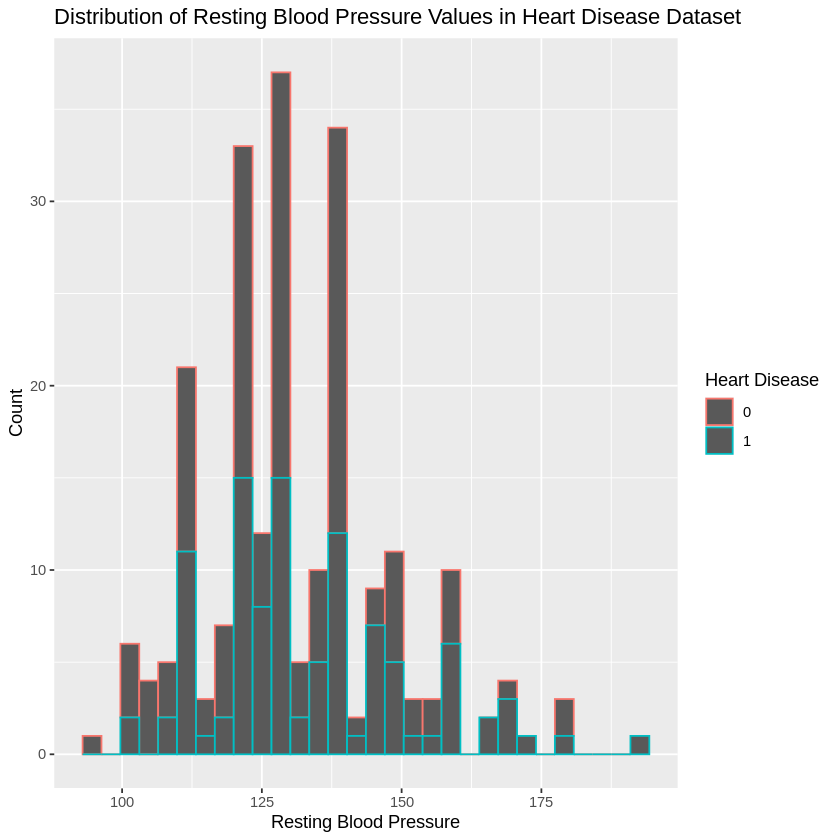

In [7]:
# histograms of every numeric variable

heart_training_hist_resting_blood_pressure<- training_data %>%
    ggplot(aes(x=resting_blood_pressure, colour = num))+
    geom_histogram(bins = 30)+
    labs(x = "Resting Blood Pressure", y = "Count", colour = "Heart Disease") +
    ggtitle("Distribution of Resting Blood Pressure Values in Heart Disease Dataset")
heart_training_hist_resting_blood_pressure

Figure 1: The distribution of patients with and without heart disease based on their resting blood pressure.

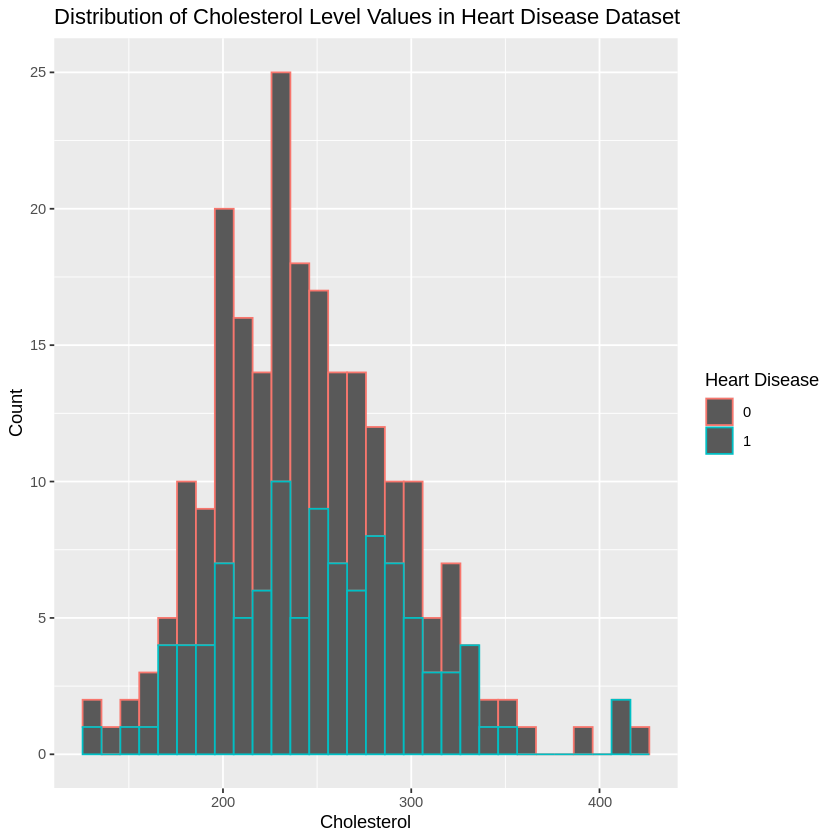

In [8]:
heart_training_hist_cholesterol<- training_data %>%
    ggplot(aes(x=cholesterol, colour = num))+
    geom_histogram(bins = 30)+
    labs(x = "Cholesterol", y = "Count", colour = "Heart Disease") +
    ggtitle("Distribution of Cholesterol Level Values in Heart Disease Dataset")
heart_training_hist_cholesterol

Figure 2: The distribution of patients with and without heart disease based on their cholesterol levels.


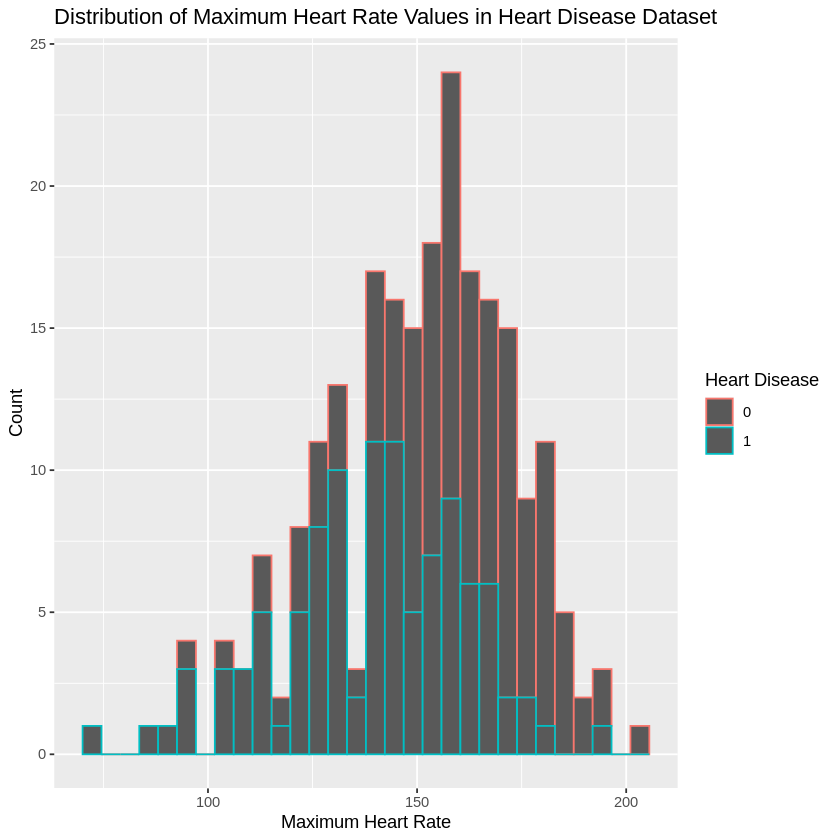

In [9]:
heart_training_max_heart_rate<- training_data %>%
    ggplot(aes(x=max_heart_rate, colour = num))+
    geom_histogram(bins = 30)+
    labs(x = "Maximum Heart Rate", y = "Count", colour = "Heart Disease") +
    ggtitle("Distribution of Maximum Heart Rate Values in Heart Disease Dataset")
heart_training_max_heart_rate

Figure 3: The distribution of patients with and without heart disease based on their maximum heart rate.


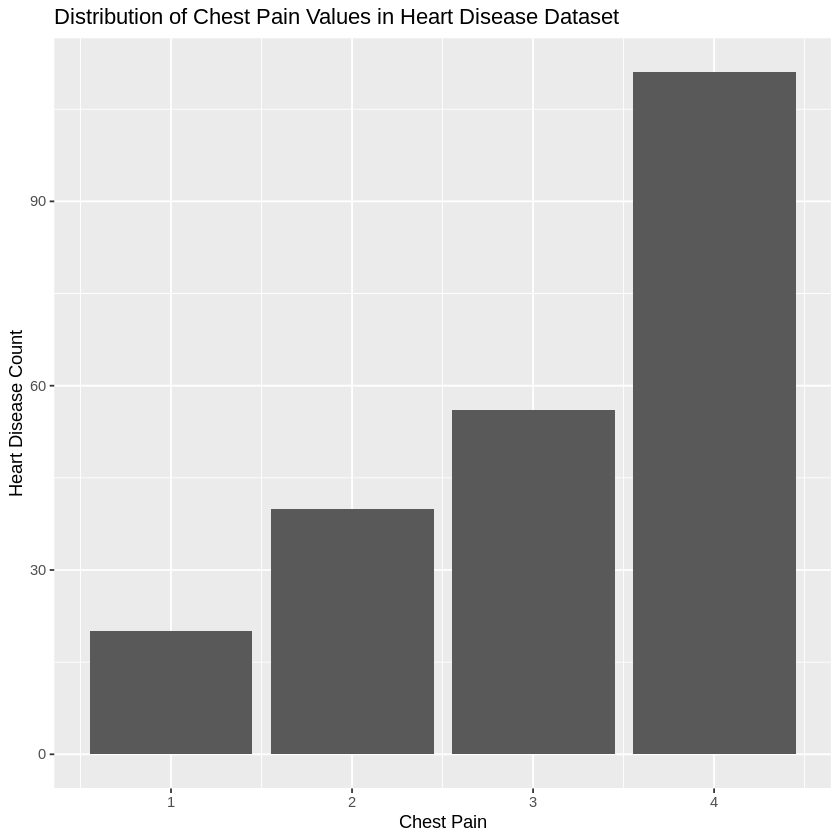

In [18]:
# !!!

heart_training_chest_pain<- training_data %>%
    ggplot(aes(x= chest_pain))+
    geom_bar()+
    labs(x = "Chest Pain", y = "Heart Disease Count") +
    ggtitle("Distribution of Chest Pain Values in Heart Disease Dataset")
heart_training_chest_pain

Figure 4: The distribution of patients with and without heart disease based on their chest pain levels.


!!!

If you refer to the histograms labelled Figure 1, Figure 2, Figure 3, and Figure 4, it is visible that in the distributions for resting_blood_pressure, cholesterol, and max_heart_rate, as the variables change there is a noticeable affect on the number of patients with heart disease which are identifiable by colour. In fig 1, we see that the higher the resting blood pressure, the greater the distribution of those with heart disease compared to those without it.In fig 2 we can see that as cholesterol increases, the distribution of patients with heart disease increases. In fig 3, we see that as the maxmium heart rate increases, the distribution of patients with heart disease falls. Finally in fig 5, there is a clear gradual increase in the distribution of those with heart disease as the level of chest pain rises.

Our initial assumption was that a high resting blood pressure would lead to an increased probability of heart disease because a high blood pressure leads to various different health complications including heart disease (Wannamethee G, 1994). We selected cholestrol because high colestrol is directly related to issues in blood flow that could lead to a heart attack (Wannamethee G, 1994), which told us that this may also be linked to heart disease. Lastly we believed that a healthy max heart rate would be aligned with a reduce risk of heart disease due to the excercise that is typically associated with it (Wannamethee G, 1994). We initially assumed that age, sex, and fasting blood pressure would also be related to heart disease but after initally including them in the model, it proved otherwise. This is also backed up by research that finds no relationship with these variables and heart rate, the main factor that contributes to heart disease (Wannamethee G, 1994). Finally, we assumed that chest pain would be related to various different diseases such as lung cancer and heart disease. This was backed up by research by the CDC that shows chest pain as a symptom of coronary heart disease (CDC, 2022). These relationships are also shown in our ggpairs visualization below labelled fig 4 that shows the correlation or lack there of between these variables and heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



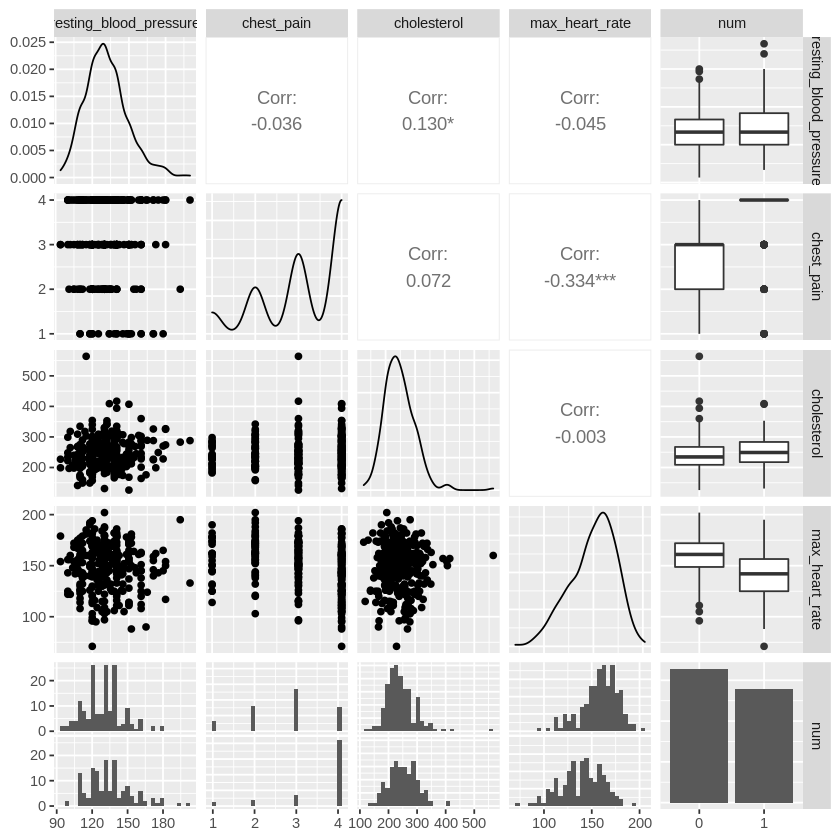

In [10]:
# comparing variable correlations

correlations <- ggpairs(heart_disease_data)
correlations

Figure 5: A visualization showing the correlation of variables with respect to each other in the dataset.

#### Model Tuning

In [11]:
# balancing and scaling the data in the classification recipe

heart_disease_recipe <- recipe(num ~ ., data = training_data) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [12]:
# creating the tuning classification model 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [13]:
# cross-validation on training data to determine best k-value
set.seed(2022) 

k_values <- tibble(neighbors = c(1:50))

heart_disease_vfold <- vfold_cv(training_data, v = 5, strata = num)

knn_tune_fit <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_disease_vfold, grid = k_values) |>
    collect_metrics()

! Fold1: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.



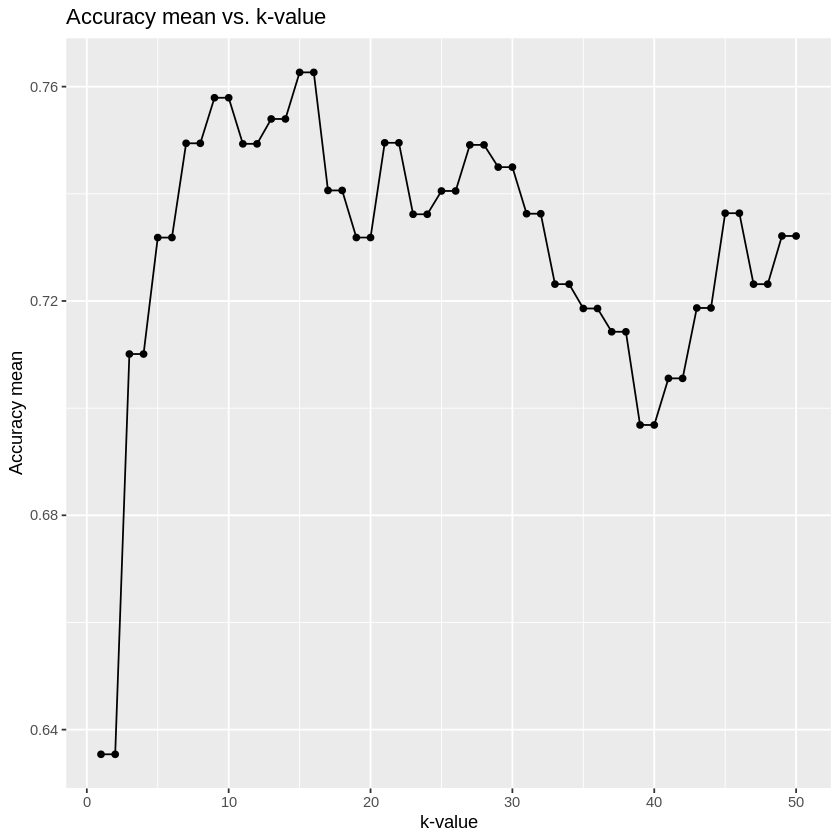

In [14]:
# plotting accuracy values to determine the best k-value

knn_tune_accuracies <- knn_tune_fit |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

accuracies <- ggplot(knn_tune_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "k-value", y = "Accuracy mean") +
    ggtitle("Accuracy mean vs. k-value")

accuracies

fig 6: Visualization showing the optimum k value with respect to accuracy.

In [16]:
# choosing the best k-value

knn_tune_preview <- knn_tune_accuracies |>
    filter(neighbors %in% c(14:19))
knn_tune_preview

chosen_k <- 15

neighbors,mean
<int>,<dbl>
14,0.7539701
15,0.7626658
16,0.7626658
17,0.7406324
18,0.7406324
19,0.7318401


Table 4: A table showing the accuracy of the K values for optimal selection.

#### Optimal Model Creation 

In [17]:
# creating model with chosen k

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = chosen_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_spec) |>
    fit(data = training_data)

In [18]:
# predicting on test data 

prediction <- knn_fit |>
    predict(testing_data) |>
    bind_cols(testing_data)

prediction_data <- prediction |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy")

prediction_data

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7368421


Table 5: Optimal model accuracy on testing data.

#### Optimal Model Visualization

In [22]:
# visualizing predictions
# !!!

prediction

.pred_class,resting_blood_pressure,chest_pain,cholesterol,max_heart_rate,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,120,2,263,173,0
0,172,3,199,162,0
0,150,3,168,174,0
⋮,⋮,⋮,⋮,⋮,⋮
0,152,3,212,150,1
1,124,4,197,136,1
0,130,2,236,174,1


#### Methods:
* Explain how you will conduct either your data analysis and which variables/columns you will use. (Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?)
* Describe at least one way that you will visualize the results

We will select the columns resting_blood_pressure, cholesterol, max_heart_rate, and num, this is a change from our proposal; because the correlation was better when did not include age, sex, chest_pain and fasting_blood_pressure.

Our assumption was that a high resting blood pressure would lead to an increased probability of heart disease because a high blood pressure leads to various different health complications including heart disease (source). We selected cholesterol because high cholesterol is directly related to issues in blood flow that could lead to a heart attack (source), which told us that this may also be linked to heart disease. As stated we previously found that including other variables messed with the accuracy of our model so we chose to only include these as those variables would not be helpful in prediction. 

To increase the accuracy of the data prediction, we optimize the data itself. In the previous version, the "num" column represented four different kinds of heart disease with values 1,2,3, and 4. It also had a value "0" for patients who don't have heart disease. We simplified this to make it so that we only have two values in this column, "0" and "1", to represent whether or not a patient has heart disease. This is more aligned with the question that we are asking to see if we can predict heart disease given the variables of their health characteristics we  are using. 

In the next step, we do the data classification. After using cross-validation to calculate accuracy for each value of 𝐾 in a reasonable range, we create a plot to choose the best k for our model with the most fantastic accuracy.

Finally, we choose the best k, 24, and create the model for the selected k.


#### Discussion:
##### Summarize what you found

We found that our KNN-classification model using resting blood pressure, chest pain type, cholesterol, and max heart rate predicted on our testing set with approximately 73.68% accuracy (Table 5). Through the process of refining this model, we found that chest pain in particular improved the model's accuracy, suggesting that chest pain has a high correlation with a patient's heart disease status. 

[will elaborate with references to charts and graph when i figure out ggplot overlays tmrw] ; !!!

##### Discuss whether this is what you expected to find?

There are three expectations we mentioned in our proposal.
  * A link between particular variables and heart disease
  
###### People who have heart disease are likely to have a little bit higher resting_blood_pressure, slightly higher cholesterol, and lower cholesterol
  * A list of variables that are linked to heart disease and the variable that has the most significant effect on the likelihood of heart disease
  
###### We found that resting_blood_pressure, cholesterol, and max_heart_rate is related to heart disease.
###### Amount all the variables, max_heart_rate has the most significant effect on the likelihood of heart disease.

###### After researching the reference material, we found that high blood pressure and cholesterol are considered risk factors for heart disease, and high blood pressure and high cholesterol will also affect the max heart rate. Therefore, we can infer to a certain extent whether a person has a disease or not with these three factors. 

  * An accurate predictive model that can help detect the possibility of heart disease
  
###### We already have the predictive classification model, which has a k value of 24.


##### Discuss what impact could such findings have?

##### Discuss what future questions could this lead to?

We have proven that it is possible to build a model that is 70% accurate at determining whether or not a patient has heart disease. This could lead to further questions about accuracy as well, for instance:

* How could this model or other models be improved to more accurately predict heart disease?
* Using the variables we have identified, it is now possible to create a new model that answers the question of: given that a person has been identified as at risk of heart disease, what is the most effective way to lower their likelihood of heart disease.

Our model failed to accurately predict heart disease when we included the age variable, this leaves room for further questions about preventative measures on younger people such as:

* What is the best variable to help identify the risk of heart disease amongst 20-30 year old people?
* If heart disease is not easy to predict amongst this age group, is it possible to identify other diseases such as cancer with more accuracy without the exclusion of the age variable?

The model that we built was only 50% accurate at predicting heart disease when we included the four different types of heart disease, this allows for further questions on the topic such as:

* Is it possible to build a model that accurately predicts the type of heart disease a patient will have given the variables of their health characteristics? 
* What variables are best linked to the different forms of heart disease and how can they individually be treated?


#### References:

Here is an annotated list of five references that relate to heart disease. To find them, we searched google scholar for scholarly articles from the past five years the included the terms "heart", "disease", "predict", and "data"

##### Zriqat, I. A., Altamimi, A. M., & Azzeh, M. (2017). A comparative study for predicting heart diseases using data mining classification methods. arXiv preprint arXiv:1704.02799.

    Incorrect diagnosis of heart disease has led many researchers to investigate better predictive methods. This paper uses "five data mining classifying algorithms, with large datasets" (abstract para 1) to propose a more effective decision making model. Five classifiers were used: Naïve Bayes, Decision Tree, Discriminant, Random Forest, and Support Vector Machine. Decision tree was the most accurate with a 99.0% rate.


##### Latha, C. B., & Jeeva, S. C. (2019). Improving the accuracy of prediction of heart disease risk based on ensemble classification techniques. Informatics in Medicine Unlocked, 16, 100203. https://doi.org/10.1016/j.imu.2019.100203


    Machine learning can predict using known data via classification methods that recognize patterns. This paper proposes the use of ensemble classification, that is using multiple classifiers. Ensemble classification was applied to predicting heart disease, and this paper also shows in purpose in "predict[ing] disease at an early stage" (abstract para 1). Ensemble classification such as bagging and boosting improved the accuracy of poor classifiers, and it increased week prediction models by 7%.


##### Mohan, S., Thirumalai, C., & Srivastava, G. (2019). Effective heart disease prediction using hybrid machine learning techniques. IEEE Access, 7, 81542–81554. https://doi.org/10.1109/access.2019.2923707


    Machine Learning is effective at predicting heart disease, one of the leading causes of death in humans. ML has been used in the Internet of Things. The model proposed in this paper uses various classification methods to predict heart disease, with an accuracy of 88.7%.


##### Rao, J. N., & Prasad, R. S. (2021). An enhanced novel Dynamic Data Processing (ENDDP) algorithm for predicting heart disease in machine learning. International Journal of Scientific Research in Computer Science, Engineering and Information Technology, 94–104. https://doi.org/10.32628/cseit206429


    Machine Learning is increasing in development and can solve complex problems, such as the most difficult one in the medical world, the prediction of heart disease. Improving the algorithms that use complex data sets can improve diagnoses in the medical world. "In this article, An Enhanced New Dynamic Data Processing (ENDDP) Algorithm is developed to predict the early stages of heart disease" (abstract para 1).


##### Reddy, G. T., Reddy, M. P., Lakshmanna, K., Rajput, D. S., Kaluri, R., & Srivastava, G. (2019). Hybrid genetic algorithm and a fuzzy logic classifier for heart disease diagnosis. Evolutionary Intelligence, 13(2), 185–196. https://doi.org/10.1007/s12065-019-00327-1 


    "For the past two decades, most of the people from developing countries [have been] suffering from heart disease" (abstract para 1). Early diagnosis can mitigate risk and cost. The adaptive genetic algorithm with fuzzy logic (AGAFL) is a prediction model for heart disease. Experiments have proved this model has outperformed prior models.


##### Wannamethee G, Shaper AG. (1994). The association between heart rate and blood pressure, blood lipids and other cardiovascular risk factors. J Cardiovasc Risk. 223-30. doi: 10.1177/174182679400100307.

#####   CDC. (2022). Other Conditions Related to Heart Disease | cdc.gov. Centers for Disease Control and Prevention. Retrieved from cdc.gov/heartdisease/other_conditions.htm#:~:text=and%20unstable%20angina.-,Angina%2C%20a%20symptom%20of%20coronary%20artery%20disease%2C%20is%20chest%20pain,It%20may%20feel%20like%20indigestion.

